# Fruit Classification using Convolutional Neural Networks in Python

---
Autores: David Cardona Duque
---

## Contexto general y tema de estudio

Este proyecto presenta una demostración de cómo se pueden utilizar técnicas de aprendizaje profundo, específicamente redes neuronales convolucionales, para clasificar 10 tipos de frutas. El objetivo es explorar cómo las redes neuronales convolucionales pueden ser utilizadas para identificar patrones y relaciones en los datos de las imágenes de frutas, y cómo estos patrones pueden ser utilizados para predecir la clase a la que pertenece una nueva imagen de fruta.

## Problema o pregunta de estudio y motivación

La clasificación de imágenes de frutas es un problema importante en la agricultura, ya que puede ayudar a identificar y clasificar diferentes tipos de frutas, lo que puede tener implicaciones importantes en la calidad y el precio de las frutas. El objetivo de este proyecto es responder a la pregunta: ¿cómo se pueden utilizar técnicas de aprendizaje profundo para clasificar 10 tipos de frutas y cómo pueden estas técnicas ser útiles en la práctica agrícola?

## Objetivo del informe

El objetivo de este informe es proporcionar una demostración detallada del uso de redes neuronales convolucionales en Python para clasificar 10 tipos de frutas. En este informe, se describe el conjunto de datos utilizado, se presentan los resultados de la red neuronal convolusional utilizada, y se discuten las implicaciones de los resultados. También se proporciona código detallado y comentarios para permitir que otros usuarios reproduzcan los resultados y exploren los datos por sí mismos.


In [ ]:
#from zipfile import ZipFile as zs
#zip = zs('train.zip')
#zip.extractall()

### Librerias iniciales

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
import os 
import matplotlib.image as mpimg
import random
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import load_img, img_to_array
import pathlib
import numpy as np

In [2]:
# Librerias usadas
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import itertools
import math
import os
from sklearn.metrics import confusion_matrix
from skimage import io 
from skimage.transform import rescale, resize, downscale_local_mean
from random import randint, choice, choices
from tensorflow import keras
from PIL import Image
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import cv2
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Activation, BatchNormalization

## Descripcion



Se buscará clasificar 10 tipos de especies de frutas a través de imágenes. Para ello se tienen imagenes de entrenamiento y validación previamente seleccionada, el dataset completo contaba con 32 tipos de frutas, con el objetivo de reducir el tiempo computacional usado se seleccionaron 10 de estas para hacer el trabajo. El dataset cuenta con imagenes de cada fruta en diferentes angulos y con diferentes rotaciones aplicadas para un mejor resultado del modelo, ademas las imagenes proporcionadas son segmentadas, esto quiere decir que lo unico en la imagen es la fruta en cuestion, es decir no hay otro objetos que interfieran con el proceso de identificacion de caracteristicas.

En resumen es un dataset extremandamente bueno y esperamos muy buenos resultados.



### Clases a utilizar

A continuacion se indica el directorio de los datos de entrenamiento, estaran ubicados en el mismo lugar que el cuaderno.

In [3]:
train_path = "../content//train/" #Direccion de los datos de entrenamiento


Se muestran y se almacenan los nombres de las clases que vamos a usar en nuestro modelo, nuestros datos de entrenamiento estan organizados en carpetas por clase, debido a esto nos resultara facil observar las clases.

In [4]:
data_dir = pathlib.Path(train_path) # conviene la ruta de entrenamiento en un ruta de python para un mejor manejo
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # Crea una lista de las clases con los subdirectorios
print(class_names)

['Apple Braeburn' 'Banana' 'Cantaloupe' 'Cherry' 'Limes' 'Orange' 'Papaya'
 'Peach' 'Pineapple' 'Raspberry']


Se observara una imagen cualquiera de cualquier clase.

In [5]:

def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class

  random_image = random.sample(os.listdir(target_folder), 100)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  return img

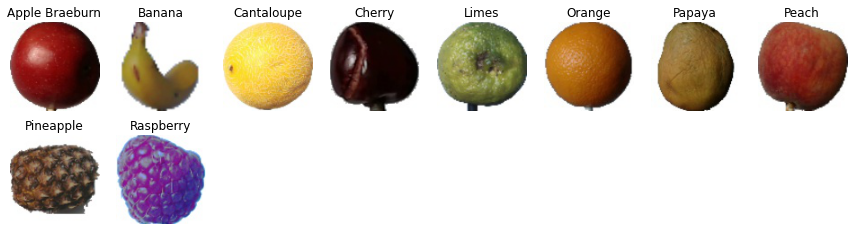

In [6]:
plt.figure(figsize = (15,10))
for i in range(10):
    plt.subplot(5,8,i+1)
    img = view_random_image(target_dir=train_path,
                        target_class=class_names[i])

## Preparar los datos a utilizar.


Crearemos nuestro dataset de entrenamiento. A continuacion crearemos un dataframe con el nombre del archivo, su ruta y la clase a la que pertenece

In [7]:
train_val_data = {'path' : [],
       'filename': [],
       'label': []}
for dirpath, dirnames, filenames in os.walk(train_path):
    for f in filenames:
        train_val_data['path'].append(dirpath)
        train_val_data['filename'].append(f)
        train_val_data['label'].append(f.split('_')[0])

In [8]:
train_val_data_df = pd.DataFrame(train_val_data)
train_val_data_df.head()

,path,filename,label
0,../content//train/Raspberry,Raspberry_5.jpg,Raspberry
1,../content//train/Raspberry,Raspberry_37.jpg,Raspberry
2,../content//train/Raspberry,Raspberry_336.jpg,Raspberry
3,../content//train/Raspberry,Raspberry_390.jpg,Raspberry
4,../content//train/Raspberry,Raspberry_355.jpg,Raspberry


## Lectura de imagenes y adecuacion de los datos

Aqui podemos observar la cantidad de las imagenes y su dimension correspondiente, ademas separamos las labels de todas las imagenes en una lista para manejos futuros.

In [9]:

images = []
label = [] 

for _, d in train_val_data_df.iterrows():
    img = load_img(os.path.join(d['path'],d['filename']))
    images.append(img_to_array(img))
    label.append(d['label'])

In [10]:
images = np.array(images)
labels = np.array(label)
print(f"Cantidad de imagenes y su dimension: {images.shape} and Dimension de las clases: {labels.shape}")

Cantidad de imagenes y su dimension: (4899, 100, 100, 3) and Dimension de las clases: (4899,)


### Manejo de la cantidad de imagenes por clase 

#### Convertir los nombres de las clases en labels

In [11]:
class_indices = dict(zip(class_names, range(len(class_names))))

labels_encoded = list(map(class_indices.get, labels))

#CONVERTIR A CATEGORICAS USANDO KERAS

label_categorical = tf.keras.utils.to_categorical(labels_encoded, num_classes=len(class_names), dtype='uint8')

#### Analisis de cantidad de datos por clase

Podemos observar que las 10 clases estan extremadamente balanceadas en comparacion una con otra. Por esto no es necesaro generar un balanceo de clases a la hora del modelo, todas las clases deben tener un peso aproximado de 1, lo cual se comprueba al consultar el peso recomendado.

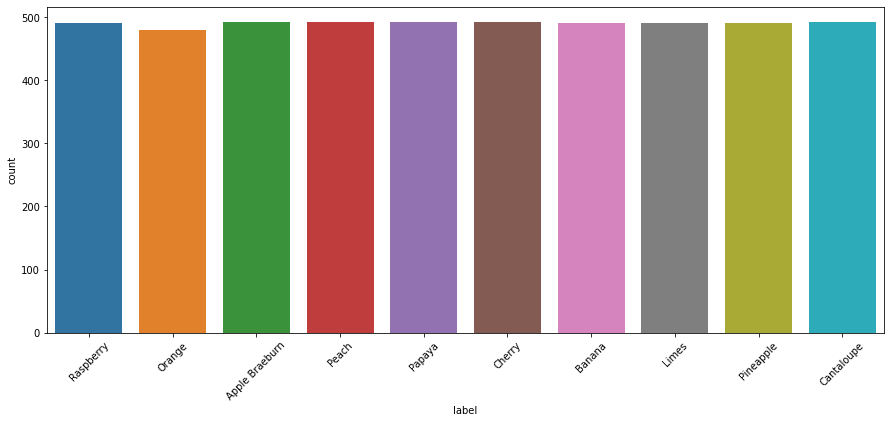

In [12]:
plt.figure(figsize = (15,6))
#data_df['label'].value_counts().plot(kind='barh')
sns_cntplot = sns.countplot(x='label', data=train_val_data_df)
plt.xticks(rotation=45);

In [13]:
class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=(0,1,2,3,4,5,6,7,8,9),   #Levels de los labels usados.
                                     y=labels_encoded)                       #Conjunto de labels de los datos de entrenamiento

In [14]:
class_weights

array([0.99573171, 0.99979592, 0.99573171, 0.99573171, 0.99979592,
       1.02275574, 0.99573171, 0.99573171, 0.99979592, 0.99979592])

## Separcion de los datos de entrenamiento, prueba y validacion.

A continuacion creamos nuestras respectivas variables de interes para el analisis, se crea el set de validacion a partir del de entrenamiento ya que el dataset no provee un set con este proposito, por lo tanto, se usar un 10% de los datos para el set de prueba, un 20% de los datos para el set de validacion y un 70% para entrenamiento.

In [15]:
# Dividimos los datos para entrenamiento y prueba
#train_im, valid_im, train_lab, valid_lab
X_train1, X_test, y_train1, y_test = train_test_split(images, label_categorical, test_size=0.10, 
                                                            stratify=label_categorical, #10% datos prueba
                                                            random_state=40, shuffle = True)

In [16]:
# Dividimos los datos para entrenamiento y prueba
#train_im, valid_im, train_lab, valid_lab
X_train, X_valid, y_train, y_valid = train_test_split(X_train1, y_train1, test_size=0.20, 
                                                            stratify=y_train1, #70% dato de entrenamiento y 20% para validacion
                                                            random_state=40, shuffle = True)

In [17]:
print ("Dimension de los datos de entrenamiento: ", X_train.shape)
print ("Dimension de los datos de entrenamiento: ", y_train.shape)
print()
print ('Dimension de los datos de prueba: ', X_test.shape)
print ('Dimension de los datos de prueba: ', y_test.shape)
print()
print ("Dimension de los datos de validacion: ", X_valid.shape)
print ("Dimension de los datos de validacion: ", y_valid.shape)


Dimension de los datos de entrenamiento:  (3527, 100, 100, 3)
Dimension de los datos de entrenamiento:  (3527, 10)

Dimension de los datos de prueba:  (490, 100, 100, 3)
Dimension de los datos de prueba:  (490, 10)

Dimension de los datos de validacion:  (882, 100, 100, 3)
Dimension de los datos de validacion:  (882, 10)


Aqui podemo observar la cantidad de imagenes para entrenamiento, las cuales son: 3527, la cantidad de imaganes para prueba, las cuales son: 490 y por ultimo la cantidad de imagenes para validacion, las cuales son: 882.

Aqui crearemos los dataset de entrenamiento y de prueba los cuales usaremos mas adelante con la API tf.keras

In [18]:

training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
validation_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

check_list = list(training_data.as_numpy_iterator())



Podemos observar finalmente las imagenes de nuestros datos de entrenamiento, podemos ver mas de 1 por clase y observamos que si existen rotaciones y diferentes angulos de cada fruta.

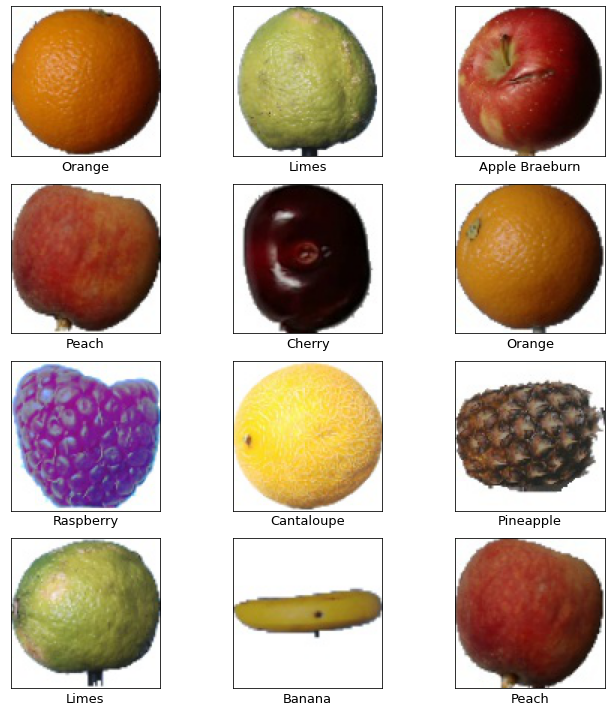

In [19]:

fig = plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(check_list[i][0]/255.)
    plt.xlabel(class_names[np.argmax(check_list[i][1])], fontsize=13)
plt.tight_layout()    
plt.show()

## Declaracion de la variables y clases finales a utilzar

*X_train*: Variable de imagenes de entrenamiento.

*y_train*: Label que asigna el tipo de clase de imagenes de entrenamiento.


*X_test*: Variable de imagenes de prueba.

*y_test*: Label que asigna el tipo de clase de las imagenes de prueba.

*X_valid*: Variable de imagenes de validación.

*y_valid*: Label que asigna el tipo de clase de las imagenes de validación.

**Clasifiación de Frutas**:

<center>

|Label|Nombre de fruta|
|-----|------------------|
|0|Apple Braeburn|
|1|Banana|
|2|Cantaloupe|
|3|Cherry|
|4|Limes|
|5|Orange|
|6|Papaya|
|7|Peach|
|8|Pineapple|
|9|Raspberry|

## Preprocesamiento tf.keras

A continuacion se hace 3 procesos importantes de preprocesamiento, el primero en definirse es el de normalizar las imagenes mediante la capa de Rescaling de tf.keras, lo cual consigue que el modelo de color funcione al poner los valores de los pixeles en nuestra imagen de una manera correcta, lo segundo es que aunque el dataset tiene ya bastantes angulos en las imagenes se probara hacer un "flip" random a las imagenes para un mejor entreno del modelo, esto se hace mediante la capa de tf.keras llamada RandomFlip, esto ultimo lo podemos ver con la primera imagen mostrada a la cual es la que s ele aplico el flip y la segunda la cual no lo tiene aplicado.

Por otro lado se hace un proceso de batch, con un batch size de 128, esto significa que alimentaremos el modelo a 128 imagenes a la vez, lo probaremos y en caso de ser ineficiente variaremos.

Y por ultimo utilizamos una tecnica de la API tf.keras la cual se llama Prefetching el cual solapa el preprocesamiento y la ejecucion del modelo en el paso de entrenamiento, si el modelo esta digamos ejecutando el paso s, el modelo ya esta leyendo los datos del paso s+1, el número de elementos a prefetch debe ser igual (o posiblemente mayor) que el número de batch consumidos por un solo paso de entrenamiento, este numero se obtiene de manera automatica con tf.data.AUTOTUNE.

In [20]:
rescale_data = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1/255.) #para los pixeles -> se debe hacer /255 NORMALIZAR
])
#Data Pipeline using`tf.data` & Prefetching
data_augmenation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode = "horizontal"), #le hace un flip a la imagen
])

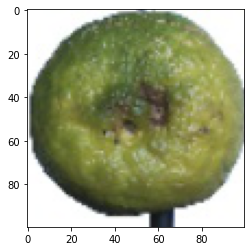

In [23]:
random_image_index = random.randint(0,len(X_train))
img = rescale_data(X_train[random_image_index])
img = data_augmenation(img)
plt.imshow(img)

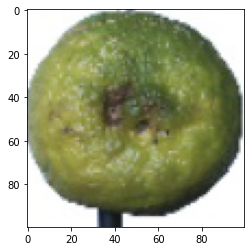

In [24]:
img2=X_train[random_image_index]/255
plt.imshow(img2)

In [25]:
BATCH_SIZE = 128 
AUTOTUNE = tf.data.AUTOTUNE 

def prepare(ds, shuffle=False, augment = False, test = False):
    if test:
        ds = ds.map(lambda x,y: (rescale_data(x),y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (rescale_data(x), y), num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000) #mezcla los datos
    
    #batch DATOS
    ds = ds.batch(BATCH_SIZE)
    
    # Solo hace flip en el dataset de entrenamiento.
    if augment:
        ds = ds.map(lambda x, y: (data_augmenation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    
    # Aplica el prefetch en todos los dataset.
    return ds.prefetch(buffer_size=AUTOTUNE) #prefetching con autotune

In [26]:
train_ds = prepare(training_data, shuffle = True, augment = True)
test_ds = prepare(test_data)
valid_ds=prepare(validation_data,test=True)


## Modelo

### Configuracion de callbacks

In [27]:
#Librerias necesarias para el uso de callbacks
from pathlib import Path
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import datetime

def create_callbacks(output_dirs, model_name, stopping_patience, lr_patience, initial_lr):

    # Asegura que las carpetas donde se almacenarán las salidas de los "callbacks" estén creadas.
    for output_dir in output_dirs.values():

        Path(output_dir).mkdir(parents=True, exist_ok=True)

    csv_logger = CSVLogger(os.path.join(output_dirs["/training_metrics"], f"{model_name}.csv"))
    early_stopping = EarlyStopping(patience=stopping_patience, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(os.path.join(output_dirs["/models"], f"{model_name}.hdf5"),
        verbose=1,
        save_best_only=True
    )

    # Reduce la tasa de aprendizaje a la mitad (como máximo 5 veces) en caso de no haber 
    # mejora durante varios "epochs".
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=lr_patience, min_lr=initial_lr * (0.5 ** 5))

    timestamp = datetime.datetime.now().strftime("%d%m%Y_%H%M%S")
    tensorboard = TensorBoard(
        os.path.join(output_dirs["/tensorboard_logs"], f'{model_name}_{timestamp}'),
        histogram_freq=1,
        write_images=True,
        write_steps_per_second=True,
        profile_batch=(10, 20)
    )

    return csv_logger, early_stopping, model_checkpoint, reduce_lr, tensorboard

In [48]:
#Crea los directorios de callbacks, utilizar en caso de no tenerlos creados en la misma ruta donde se tiene guardado el cuaderno
#os.mkdir('outputs')
#os.mkdir('outputs/training_metrics')
#os.mkdir('outputs/models')
#os.mkdir('outputs/tensorboard_logs')

In [28]:
OUTPUT_DIRS = {
    #Para escritorio. Atentos a la jerarquía de archivos.
    #"/training_metrics": "./outputs/training_metrics",
    #"/models": "./outputs/models",
    #"/tensorboard_logs": "./outputs/tensorboard_logs"

    #Donde tengan creadas estas carpetas en su drive. OJO que solo cambió el valor del diccionario.
    "/training_metrics": "../content//outputs/training_metrics",
    "/models": "../content//outputs/models",
    "/tensorboard_logs":"../content//outputs/tensorboard_logs"
}

In [29]:
MODEL_NAME = "model_1"      #Nombre del modelo
STOPPING_PATIENCE = 2  # Cantidad de "epochs" sin mejora para detener el entrenamiento.
LR_PATIENCE = 1  # Cantidad de "epochs" sin mejora para reducir la tasa de aprendizaje.
INITIAL_LR = 0.0001

callbacks = create_callbacks(OUTPUT_DIRS, MODEL_NAME, STOPPING_PATIENCE,
                             LR_PATIENCE, INITIAL_LR)

### Creacion del modelo

Se usará el modelo secuencial de keras. Además, se va a extraer la información más representativa de las imagenes por medio de filtros dados por capas convolucionales para poder clasificar las distintas especies con su respectivo label.

Usaremos una funcion de activacion relu para  mejorar sus resultados antes de pasar a la siguiente neurona, lo cual mejora los modelos significativamente, sera Relu ya que es una de las más usada para redes CNN  y su funcionamiento sustituye todos los valores negativos recibidos en la entrada por ceros.

Usaremos una capa de Max pooling para reducir el tamaño de las imágenes y, a la vez, preservar sus características más esenciales.  consiste en conservar en cada paso, el valor maximo de la ventana de filtro.

Ademas, usaremos softmax porque se ha mostrado bastante funcional para procesos de calificacion.

Por otro lado, como optimizador usaremos Adam porque es un algoritmo reciente que esta basado en las fortalezas de algoritmos de optimizacion anteriores y porque es eficiente desde el punto de vista computacional, requiere poca memoria y es muy adecuado para problemas que son grandes en términos de datos y/o parámetros, lo cual describe las necesidades de un problema basado en redes neuronales convolucionales.

Por ultimo, usaremos como funcion de perdida la categorical crossentropy ya que es un método para evaluar lo bien que el algoritmo modela el conjunto de datos. Si las predicciones son totalmente erróneas, la función de pérdida arrojará un número mayor. Si son bastante buenas, dará un número más bajo, ademas se usa para modelos de clasificación multiclase en el que hay dos o más etiquetas de salida, lo cual describe nuestro modelo.


In [30]:
model_1 = tf.keras.models.Sequential([
    #Caracterizacion de las imagenes
    tf.keras.layers.Conv2D(filters=5, 
                          kernel_size = 3,
                          activation = "relu",
                          input_shape = (100,100,3)),
    tf.keras.layers.MaxPool2D(pool_size =2,
                             padding='valid'),
    
    #Etapa de clasificacion
    tf.keras.layers.Flatten(),  #Aplanar los datos a un vector unidimensional
    tf.keras.layers.Dense(len(class_names), activation="softmax")#Implementza la operación f(z)
])

model_1.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

Siempre hay que tener en cuenta la cantidad de parámetros P que se van a variar ya que estos se cambian con esta permutación:

<center>

Número de variaciones totales = $2*P*epochs$

</center>

$2*P$ = Número de variaciones hacia adelante + número de variaciones hacia atrás.

In [31]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 5)         140       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 5)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 12005)             0         
                                                                 
 dense (Dense)               (None, 10)                120060    
                                                                 
Total params: 120,200
Trainable params: 120,200
Non-trainable params: 0
_________________________________________________________________


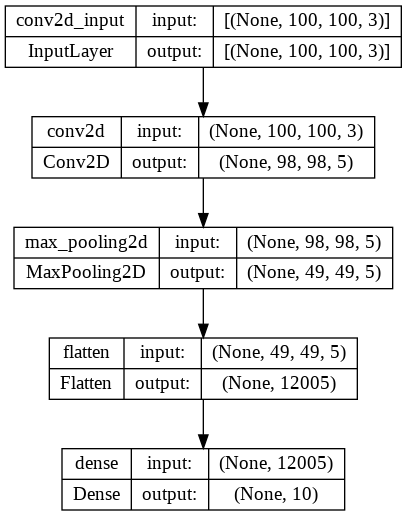

In [32]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

Arriba, se puede ver que la salida de cada capa Conv2D y MaxPooling2D es un tensor de forma 3D (alto, ancho, canales). Las dimensiones de ancho y alto tienden a encogerse a medida que avanza en la red. 

**capas densas en la parte final de la red**


Para completar el modelo, se introducirá el último tensor de salida de la base convolucional en una o más capas densas (completamente conectadas) para realizar la clasificación. Las capas densas toman vectores como entrada (que son 1D), mientras que la salida que se tiene hasta el momento es un tensor 3D. Primero, se debe aplanar (o desenrollar) la salida 3D a 1D, luego se agrega una o más capas densas en la parte superior. se tienen 10 clases de salida, por lo que usa una capa Densa final con 10 salidas.

### Ajuste del modelo

In [33]:

history_1 = model_1.fit(train_ds,
                       epochs =20,
                       validation_data= test_ds,
                        callbacks=callbacks)

Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 1.0270 - accuracy: 0.7040
Epoch 1: val_loss improved from inf to 0.17701, saving model to ../content//outputs/models/model_1.hdf5
28/28 [==============================] - 15s 496ms/step - loss: 1.0270 - accuracy: 0.7040 - val_loss: 0.1770 - val_accuracy: 0.9735 - lr: 0.0010
Epoch 2/20
28/28 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 0.9821
Epoch 2: val_loss improved from 0.17701 to 0.05194, saving model to ../content//outputs/models/model_1.hdf5
28/28 [==============================] - 16s 551ms/step - loss: 0.0994 - accuracy: 0.9821 - val_loss: 0.0519 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9980
Epoch 3: val_loss improved from 0.05194 to 0.02734, saving model to ../content//outputs/models/model_1.hdf5
28/28 [==============================] - 13s 471ms/step - loss: 0.0346 - accuracy: 0.9980 - val_loss: 0.0273

El modelo solo en lo que respecta a "accuracy" y funciones de perdida tanto en prueba como en entrenamiento es extremadamente bueno, teniendo un overfitting de 0, se hacen la cantidad maxima de epochs debido a que el valor de la funcion de perdida siempre mejora en cada uno, se limita a 20 ya que el modelo se considera extremandamente bueno en esta instancia

## Grafico de exactitud y funcion de perdida

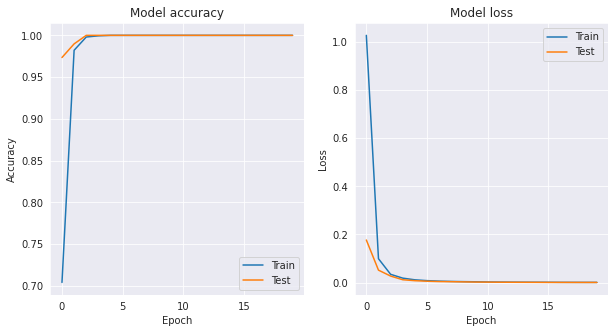

In [38]:
#Uso de gráficos para métricas a partir de los datos creados por los callbacks.
import seaborn as sb
def plot_learning_curves(training_metrics_csv_path):

    training_metrics = pd.read_csv(training_metrics_csv_path)

    with sb.axes_style("darkgrid"):
        
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        # Precisión ("accuracy").
        ax1.plot(training_metrics["accuracy"])
        ax1.plot(training_metrics["val_accuracy"])
        ax1.set(title="Model accuracy", xlabel="Epoch", ylabel="Accuracy")
        ax1.legend(("Train", "Test"), loc="lower right")

        # Pérdida ("loss").
        ax2.plot(training_metrics["loss"])
        ax2.plot(training_metrics["val_loss"])
        ax2.set(title="Model loss", xlabel="Epoch", ylabel="Loss")
        ax2.legend(("Train", "Test"), loc="upper right")

plot_learning_curves(os.path.join(OUTPUT_DIRS["/training_metrics"], f"{MODEL_NAME}.csv"))

Observamos que estas graficas nos dan un resultado bastante alentador, luego de aproximadamente el epoch 5 la "accuracy" en entrenamiento y prueba se convierte en 1 y se estabiliza y en la funcion de perdida tanto como en entrenamiento como en prueba luego del epoch 5 la disminucion se estabiliza un poco, pero es escencial decir que esta a diferencia de "accuracy" si sigue mejorando con cada epoch, teniendo esto en cuenta se mantienen los 20 epochs como maximo ya que gracias a la optimizacion con tf.keras no generan mucho costo computacional y si mejoran la funcion de perdida en cierta medida.

## Evaluacion del modelo con datos de entrenamiento

### Exactitud

In [45]:
y_pred_train = model_1.predict(X_train)
rounded_labels=np.argmax(y_train, axis=1)
rounded_pred=np.argmax(y_pred_train, axis=1)

acc_train = accuracy_score(rounded_labels, rounded_pred)
print("Train set accuracy: {:.2f}".format(acc_train))

111/111 [==============================] - 10s 86ms/step
Train set accuracy: 1.00


* Accuracy: nos mide el porcentaje de casos en los cuales el modelo ha acertado

Como pudimos ver en el entrenamiento del modelo y en las graficas anteriores, la exactitud en entrenamiento es de 1, lo cual nos indica que el modelo es extremandamnete bueno clasificando frutas con los datos de entrenamiento, tanto como para hacerlo sin equivocarse.

### Matriz de confusion 

111/111 [==============================] - 8s 70ms/step
Confusion Matrix


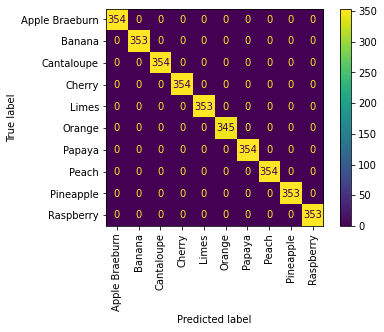

In [41]:
#Datos de entrenamiento.
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
rounded_labels=np.argmax(y_train, axis=1)
predictions=model_1.predict(X_train)
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(rounded_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(xticks_rotation='vertical', values_format='d')

Con los datos de entrenamiento,en esta matriz podemos obsevar un buen resultado, no tenemos ningun mal resultado ya que nos indica que todas las frutas fueron calificadas en su categoria indicada siendo todas verdaderos positivos.

### F1 Score

* Recall: nos indica que porcentaje de  de cada tipo de fruta somos capaces de identificar, para todos los tipos podemos identificar un 100%

* Precision: Nos indica que porcentaje de las frutas que analicemos seran efectivamente de la clase supuesta, en todos los casos es del 100%.

* F1-Score: nos combina la medida de Recall con el 'accuracy' que hemos utilizado en el resto del trabajo, asumiendo que nos importan de igual manera para nuestro analisis, para todos los tipos tenemos un F1-Score de 100%

<center>

|Label|Nombre de fruta|
|-----|------------------|
|0|Apple Braeburn|
|1|Banana|
|2|Cantaloupe|
|3|Cherry|
|4|Limes|
|5|Orange|
|6|Papaya|
|7|Peach|
|8|Pineapple|
|9|Raspberry|

In [43]:
#Entrenamiento
predictions=model_1.predict(X_train)
decoded_predictions = predictions.argmax(axis=1)
rounded_labels=np.argmax(y_train, axis=1)


print(f'Reporte de clasificación:')
print(classification_report(rounded_labels,decoded_predictions))

111/111 [==============================] - 8s 73ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       354
           1       1.00      1.00      1.00       353
           2       1.00      1.00      1.00       354
           3       1.00      1.00      1.00       354
           4       1.00      1.00      1.00       353
           5       1.00      1.00      1.00       345
           6       1.00      1.00      1.00       354
           7       1.00      1.00      1.00       354
           8       1.00      1.00      1.00       353
           9       1.00      1.00      1.00       353

    accuracy                           1.00      3527
   macro avg       1.00      1.00      1.00      3527
weighted avg       1.00      1.00      1.00      3527



### Conclusion


El dataset es muy bueno cuando se trata de datos de entrenamiento, siendo absolutamente certero, esto era esperable debido a los resultados en el entrenemiento y vamos a monitorear los datos que normalmente dan problemas que son los de prueba y validacion

## Evaluacion del modelo con datos de prueba

### Exactitud

In [46]:
y_pred_train = model_1.predict(X_test)
rounded_labels=np.argmax(y_test, axis=1)
rounded_pred=np.argmax(y_pred_train, axis=1)

acc_train = accuracy_score(rounded_labels, rounded_pred)
print("Train set accuracy: {:.2f}".format(acc_train))

16/16 [==============================] - 1s 92ms/step
Train set accuracy: 1.00


* Accuracy: nos mide el porcentaje de casos en los cuales el modelo ha acertado

Como pudimos ver en el entrenamiento del modelo y en las graficas anteriores, la exactitud en prueba es de 1, lo cual nos indica que el modelo es extremandamnete bueno clasificando frutas con los datos de prueba, tanto como para hacerlo sin equivocarse.

### Matriz de confusion

16/16 [==============================] - 1s 53ms/step
Confusion Matrix


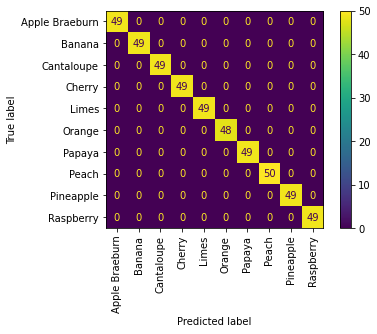

In [47]:
#Datos de prueba.
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
rounded_labels=np.argmax(y_test, axis=1)
predictions=model_1.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(rounded_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(xticks_rotation='vertical', values_format='d')

Con los datos de prueba,en esta matriz podemos obsevar un buen resultado, no tenemos ningun mal resultado ya que nos indica que todas las frutas fueron calificadas en su categoria indicada siendo todas verdaderos positivos.

### F1 Score

* Recall: nos indica que porcentaje de  de cada tipo de fruta somos capaces de identificar, para todos los tipos podemos identificar un 100%

* Precision: Nos indica que porcentaje de las frutas que analicemos seran efectivamente de la clase supuesta, en todos los casos es del 100%.

* F1-Score: nos combina la medida de Recall con el 'accuracy' que hemos utilizado en el resto del trabajo, asumiendo que nos importan de igual manera para nuestro analisis, para todos los tipos tenemos un F1-Score de 100%

<center>

|Label|Nombre de fruta|
|-----|------------------|
|0|Apple Braeburn|
|1|Banana|
|2|Cantaloupe|
|3|Cherry|
|4|Limes|
|5|Orange|
|6|Papaya|
|7|Peach|
|8|Pineapple|
|9|Raspberry|

In [48]:
#Prueba
predictions=model_1.predict(X_test)
decoded_predictions = predictions.argmax(axis=1)
rounded_labels=np.argmax(y_test, axis=1)


print(f'Reporte de clasificación:')
print(classification_report(rounded_labels,decoded_predictions))

16/16 [==============================] - 1s 53ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        49
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        49
           4       1.00      1.00      1.00        49
           5       1.00      1.00      1.00        48
           6       1.00      1.00      1.00        49
           7       1.00      1.00      1.00        50
           8       1.00      1.00      1.00        49
           9       1.00      1.00      1.00        49

    accuracy                           1.00       490
   macro avg       1.00      1.00      1.00       490
weighted avg       1.00      1.00      1.00       490



### Conclusion

El modelo es muy bueno para los datos de prueba, siendo absolutmanete certero en todos los casos, esto nos alienta a seguir testeando el modelo con los datos que nunca se usaron los cuales son los de validacion.

## Evaluacion del modelo con datos de validacion

### Exactitud

In [49]:
y_pred_train = model_1.predict(X_valid)
rounded_labels=np.argmax(y_valid, axis=1)
rounded_pred=np.argmax(y_pred_train, axis=1)

acc_train = accuracy_score(rounded_labels, rounded_pred)
print("Train set accuracy: {:.2f}".format(acc_train))

28/28 [==============================] - 3s 100ms/step
Train set accuracy: 1.00


* Accuracy: nos mide el porcentaje de casos en los cuales el modelo ha acertado

Esta siendo la prueba mas importante ya que los datos no se usaron de ninguna manera en el modelo,nos da resultados demasiado alentadores, la exactitud en validacion es de 1, lo cual nos indica que el modelo es extremandamnete bueno clasificando frutas con los datos de validacion, tanto como para hacerlo sin equivocarse.

### Matriz de confusion

28/28 [==============================] - 2s 58ms/step
Confusion Matrix


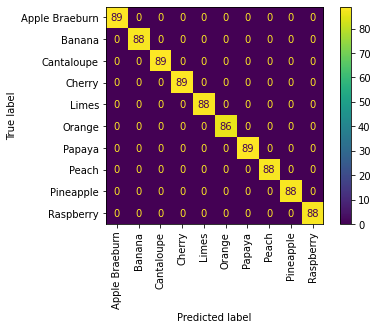

In [50]:
#Datos de validacion.
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
rounded_labels=np.argmax(y_valid, axis=1)
predictions=model_1.predict(X_valid)
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(rounded_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(xticks_rotation='vertical', values_format='d')

Con los datos de validacion,en esta matriz podemos obsevar un buen resultado, no tenemos ningun mal resultado ya que nos indica que todas las frutas fueron calificadas en su categoria indicada siendo todas verdaderos positivos.

### F1 Score

* Recall: nos indica que porcentaje de  de cada tipo de fruta somos capaces de identificar, para todos los tipos podemos identificar un 100%

* Precision: Nos indica que porcentaje de las frutas que analicemos seran efectivamente de la clase supuesta, en todos los casos es del 100%.

* F1-Score: nos combina la medida de Recall con el 'accuracy' que hemos utilizado en el resto del trabajo, asumiendo que nos importan de igual manera para nuestro analisis, para todos los tipos tenemos un F1-Score de 100%




<center>

|Label|Nombre de fruta|
|-----|------------------|
|0|Apple Braeburn|
|1|Banana|
|2|Cantaloupe|
|3|Cherry|
|4|Limes|
|5|Orange|
|6|Papaya|
|7|Peach|
|8|Pineapple|
|9|Raspberry|

In [51]:
#Validacion
predictions=model_1.predict(X_valid)
decoded_predictions = predictions.argmax(axis=1)
rounded_labels=np.argmax(y_valid, axis=1)


print(f'Reporte de clasificación:')
print(classification_report(rounded_labels,decoded_predictions))

28/28 [==============================] - 2s 55ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00        88
           2       1.00      1.00      1.00        89
           3       1.00      1.00      1.00        89
           4       1.00      1.00      1.00        88
           5       1.00      1.00      1.00        86
           6       1.00      1.00      1.00        89
           7       1.00      1.00      1.00        88
           8       1.00      1.00      1.00        88
           9       1.00      1.00      1.00        88

    accuracy                           1.00       882
   macro avg       1.00      1.00      1.00       882
weighted avg       1.00      1.00      1.00       882



### Conclusion

Por ultimo nuestro modelo tambien es excelente con los datos de validacion, mostrandonos que el modelo pasa las metricas para los 3 conjuntos de datos, lo cual nos indica que nuestro modelo es de manera certera uno muy bueno.

## Predicciones con imagenes reales 

Aunque no es  caso de estudio de este microproyecto observar como se comporta el modelo con imagenes que no cumplen con las mismas caracteristicas que las del dataset que fue entrenado, se hara un analisis breve con solo 3 clases para ver como se comporta con imagenes cualquiera de internet.

### Papaya

1/1 [==============================] - 0s 21ms/step
This image is Papaya with a 61.55 %


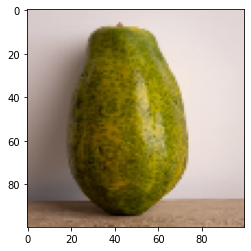

In [102]:
samplePath = pathlib.Path("/content/reales/papaya.jpg")

image = tf.keras.preprocessing.image.load_img(
    samplePath, target_size=(100, 100)
)

plt.imshow(image)
image = np.array(image)
image = image / 255.0
image = image.reshape(1,100,100,3)
predictions = model_1.predict(image)
predictions
score = tf.nn.softmax(predictions[0])
print("This image is {} with a {:.2f} %".format(class_names[np.argmax(score)],100 * np.max(predictions)))

Esta imagen tiene una papapaya posicionada de manera vertical con un piso de color ocre y fondo blanco, ademas unos colores de la fruta entre verdes y amarillos, el modelo predice de manera aceptable que es una papaya pero no de manera tan certera como con las imagenes del mismo dataset, desde el principio podemos observar que las papayas utilizadas en este son diferentes, esto posiblmente a que sean de otra variedad, lo cual nos pone un reto muy interesante y es que no es suficiente con claisficar el tipo de fruta sino que estas frutas tienen subvariedades mismas.

### Banana

1/1 [==============================] - 0s 44ms/step
This image is Banana with a 99.99 %


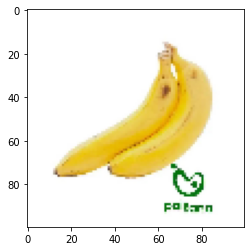

In [99]:
samplePath = pathlib.Path("/content/reales/Banano.jpg")

image = tf.keras.preprocessing.image.load_img(
    samplePath, target_size=(100, 100)
)

plt.imshow(image)
image = np.array(image)
image = image / 255.0
image = image.reshape(1,100,100,3)
predictions = model_1.predict(image)
predictions
score = tf.nn.softmax(predictions[0])
print("This image is {} with a {:.2f} %".format(class_names[np.argmax(score)],100 * np.max(predictions)))

Esta es una imagen comun de la presentacion de producto de 2 bananas, se nota un texto con una figura la cual posiblemente corresponde a la compañia dueña, inclusive con este obstaculo y con que se encuentran 2 frutas en lugar de 1, el modelo puede distinguir de manera muy certera que se trata de bananos .

### Cantaloupe

1/1 [==============================] - 0s 37ms/step
This image is Cantaloupe with a 93.14 %


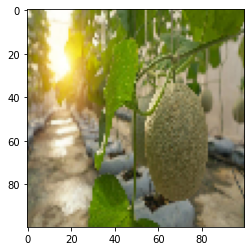

In [115]:
samplePath = pathlib.Path("/content/reales/cantaloupe.jpg")

image = tf.keras.preprocessing.image.load_img(
    samplePath, target_size=(100, 100)
)

plt.imshow(image)
image = np.array(image)
image = image / 255.0
image = image.reshape(1,100,100,3)
predictions = model_1.predict(image)
predictions
score = tf.nn.softmax(predictions[0])
print("This image is {} with a {:.2f} %".format(class_names[np.argmax(score)],100 * np.max(predictions)))

Este es el ejemplo mas ilustrativo y que demuestra que nuestro modelo aun sin haber sido entrenado para imagenes de este estilo es muy competente, en la imagen podemos ver un "Cantaloupe" el cual se encunentra rodeado por muchos mas elementos, como macestas, hojas de arboles, el sol, entre otros, aun con esto el modelo logra identificar de manera correcta la fruta, con una "accuracy" bastante decente.

## Conclusiones

* El dataset que se elige para este microproyecto es extremadamente bueno, tiene imagenes de muy alta calidad y sin ningun tipo de ruido o elemento externo que puede dañar el modelo, ademas tiene de manera nativa varias rotaciones y angulos en cada clase de las frutas.

* Las clases estan balanceadas casi a la perfeccion, esto lo podemos comprobar con el grafico de barras mostrado y con la funcion de calculo de pesos de manera automatica los cuales se aproximan mucho a 1.

* Gracias al que el dataset no proveia una cantidad de datos especifica para la validacion, se tienen que sacar de los datos de entrenamiento, esto no representa un problema significativo ya que hay datos suficientes para no empeorar exactitudes.

* El preprocesamiento con tf.keras y ademas el prefetching hace que los datos y el modelo a futuro sean mucho mas eficientes y puedan dar muy buenos resultados en poco tiempo, esto teniendo en cuenta la cantidad de datos que estamos utilizando 

* Tenemos un modelo relativamente simple, 1 capa de convolusion2D con funcion de activacion Relu y otra de Pooling mediante maxpooling, luego las capas densas utilizan softmax como funcion de activacion, ademas  tambien se utiliza el optimizador Adam. A pesar de que el modelo se puede ver siemple es suficiente para dar muy buenos resultados, lo cual nos indica que no se es necesario muchas capas o un modelo muy complejo, sino la eleccion adecuada de las mismas y unos datos que sean buenos para facilitar mucho mas el trabajo.

* Las metricas de exactitud del modelo son las mas altas posibles para imagenes de entrenamiento, prueba y validacion, lo cual nos indica que el modelo es muy compentente con el tipo de imagenes de este dataset, ademas la funcion de perdida disminuye por cada epoch, lo cual nos lleva no generar un earlystop con los callback y se considera que no es necesario disminuirlos porque el costo computacional no es grande debido al uso de tf.keras y la mejoria en la funcion de perdida es importante.

* El modelo tambien tiene la capacidad de enfrentarse a imagenes que no estan bajo las mismas condiciones que las incluidas en el dataset, aunque claramente su desempeño no va a ser tan bueno, una hipotesis para esto es que las frutas de una clase incluidas del dataset pertenecen a una misma variedad de tal fruta, pero en el mundo en general pueden existir muchas variedades con caracteristicas diferentes de, por ejemplo, papayas, lo cual requiere una complejidad mucho mayor del modelo lo cual no es alcance de este curso.